# BERTopic
* BERTopic can be viewed as a sequence of steps to create its topic representations.
* By default, the main steps, run in sequence, for topic modeling with BERTopic are:
    * Embeddings: Sentence transformers (SBERT).
    * Dimensionality reduction: UMAP
    * Clustering: HDBSCAN
    * Tokenizer: CountVectorizer
    * Weighting scheme: c-TF-IDF
    * Fine-tuned representations: optional
* However, BERTopic assumes some independence between these steps which makes it quite modular.
* In other words, BERTopic not only allows you to build your own topic model but to explore several topic modeling techniques on top of your customized topic model.

## Setup

### Imports

In [1]:
import pandas as pd
import re
from bertopic import BERTopic

pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', None)

In [2]:
import os
import sys
sys.path.insert(0, '..')
from utils import pubmed_field_definitions, abbreviations, cleaning_pipeline, process_pubmed, get_google_font

In [3]:
get_google_font.get_google_font("Roboto")

Added new font as Roboto Light
Added new font as Roboto
Added new font as Roboto
Added new font as Roboto Black


### Get spaCy stop words

In [4]:
import spacy
print(f"spaCy version: {spacy.__version__}")

activated = spacy.prefer_gpu()
print(activated)

nlp = spacy.load("en_core_web_trf")

spacy_stop_words: list[str] = list(nlp.Defaults.stop_words)

spaCy version: 3.7.2
True


### Decide whether to remake the dataset

In [5]:
remake_dataset = True

### Get your documents

#### Read in raw data

In [6]:
if remake_dataset:
    filename = os.path.join('Search Results', 'pubmed-machinelea-set.txt')

    # Open the file and read every line to determine the maximum line length.
    # This is needed to ensure Pandas doesn't truncate the input.
    # Use a 'with' statement to ensure the file is closed properly.
    with open(filename, 'r', encoding="utf8") as f:
        max_line_length: int = max(len(line) for line in f)

    # The reason for 'width' is that if a row contains a very long text string then you'll
    # need to ensure Pandas doesn't arbitrarily stop reading from that row and inadvertantly
    # truncating the input. Usually this would happen for the rows containing the abstracts.
    df_raw = pd.read_fwf(filename, header=None, widths=[max_line_length+1], skip_blank_lines=False)

    # Since I set 'header=None' when reading in the file the data is stored in a
    # single column named simply '0'.
    full_list: list[str] = df_raw[0].to_list()

#### Get the PubMed field definitions

In [7]:
if remake_dataset:
    field_dict: dict[str, str] = pubmed_field_definitions.definitions()

#### Convert the raw data into an organised DataFrame

In [8]:
if remake_dataset:
    df_orig: pd.DataFrame = pd.DataFrame(
        columns=[key for key in field_dict.keys()],
        dtype=pd.StringDtype()
    )

    df_orig = process_pubmed.get_data(full_list, field_dict, df_orig)

    df_orig = df_orig.astype({"Abstract": pd.StringDtype()})

#### Remove papers with no abstract

In [9]:
if remake_dataset:
    print(f"There are {len(df_orig)} papers.")

    # It turns out that some papers don't have an abstract.
    # Drop the rows from 'df_orig' that don't have an abstract.
    df_orig = df_orig.dropna(subset=['Abstract'])

    print(f"There are {len(df_orig)} papers with abstracts.")

There are 1285 papers.
There are 1205 papers with abstracts.


### Basic document cleaning

#### Convert strings into lists of documents

In [10]:
if remake_dataset:
    # Apply pipeline to these columns.
    cols: list[str] = ['Abstract']

    # Creates a new column by appending "_split" to the column name.
    df_orig: pd.DataFrame = cleaning_pipeline.split_into_sentences(cols, df_orig, nlp)

In [11]:
if remake_dataset:
    # Sum of the lengths of the lists in the original DataFrame.
    original_list_sum = df_orig['Abstract_split'].apply(len).sum()

    # 'expanded_df' is the new DataFrame with each element of the lists in 'Abstract_split' as a separate row.
    # All other column values are replicated for these new rows.
    expanded_df = df_orig.explode('Abstract_split')

    # Assert that the number of rows in the expanded DataFrame equals the sum of the lengths of the lists
    assert len(expanded_df) == original_list_sum, "The number of rows in the expanded DataFrame does not match the sum of the lengths of the lists in the original DataFrame."

    # Copy the expanded DataFrame back into the name of the original DataFrame.
    # And we only need the 'Abstract' and 'Abstract_split' columns.
    df_orig = expanded_df[['Abstract', 'Abstract_split']].copy(deep=True)

#### Replace known abbreviations

In [12]:
if remake_dataset:
    replacement_dict: dict[str, str] = abbreviations.exact_replacements()

In [13]:
if remake_dataset:
    # Apply pipeline to these columns.
    cols: list[str] = ['Abstract_split']

    # Creates a new column by appending "_abbv" to the column name.
    df_orig: pd.DataFrame = cleaning_pipeline.replace_abbreviations(cols, df_orig, replacement_dict)

#### Remove duplicate phrases

In [14]:
if remake_dataset:
    # Apply pipeline to these columns.
    cols: list[str] = ['Abstract_split_abbv']

    # Does not create a new column i.e. the column(s) listed here are overwritten.
    df_orig: pd.DataFrame = cleaning_pipeline.remove_duplicates(cols, df_orig, replacement_dict)

#### Remove stubs

In [15]:
if remake_dataset:
    # Apply pipeline to these columns.
    cols: list[str] = ['Abstract_split_abbv']

    # Does not create a new column i.e. the column(s) listed here are overwritten.
    df_orig: pd.DataFrame = cleaning_pipeline.remove_uppercase_colon_phrases(cols, df_orig)

#### Remove blank rows
* Remove blank rows from the current main column.

In [16]:
if remake_dataset:
    # Drop the rows from 'df_orig', column 'Abstract_split_abbv' that are empty strings.
    df_orig = df_orig[df_orig['Abstract_split_abbv'] != '']

#### Whitespace cleaning

In [17]:
if remake_dataset:
    # Apply pipeline to these columns.
    cols: list[str] = ['Abstract_split_abbv']

    # Does not create a new column i.e. the column(s) listed here are overwritten.
    df_orig: pd.DataFrame = cleaning_pipeline.whitespace(cols, df_orig)

#### Domain specific words

In [18]:
if remake_dataset:
    replacement_mapping = abbreviations.domain_specific_replacements()

    for variant, unified_term in replacement_mapping.items():
        pattern = re.compile(re.escape(variant), re.IGNORECASE)
        df_orig['Abstract_split_abbv'] = df_orig['Abstract_split_abbv'].str.replace(pattern, unified_term, regex=True)

In [19]:
if remake_dataset:
    domain_specific_terms = [
        'ClinicalBERT',
        'DistilBERT',
        'BioBERT',
        'BlueBERT',
        'BERT',
        'AlexNet',
        'SqueezeNet',
        'GoogleNet',
        'DenseNet',
        'Xception',
        'NASNetLarge',
        'GANseg'
    ]

    domain_specific_terms.extend(list(set(replacement_mapping.values())))

#### Save to file or read from file

In [20]:
if remake_dataset:
    df_orig.to_pickle("df_orig.pkl")

    with open('domain_specific_terms.txt', 'w') as f:
        for line in domain_specific_terms:
            f.write(f"{line}\n")
else:
    df_orig = pd.read_pickle("df_orig.pkl")

    domain_specific_terms = []
    with open('domain_specific_terms.txt', 'r') as f:
        for line in f:
            domain_specific_terms.append(line.strip())

#### Convert DataFrame column into a list

In [21]:
docs: list[str] = df_orig['Abstract_split_abbv'].tolist()

## Step 1 - Embedding Model
* Convert documents into embeddings.

In [22]:
from sentence_transformers import SentenceTransformer

In [23]:
# Pre-calculate embeddings.
# "all-MiniLM-L6-v2"
# "all-mpnet-base-v2"
# "thenlper/gte-large"

embedding_model = SentenceTransformer("all-mpnet-base-v2")

embeddings = embedding_model.encode(docs)

## Step 2 - Dimensionality Reduction
* Reduce the dimensionality of your embeddings.

In [24]:
from umap import UMAP

In [25]:
umap_model = UMAP(
    # The size of local neighborhood (in terms of number of neighboring sample points) used for
    # manifold approximation.
    # Larger values result in more global views of the manifold, while smaller values result in
    # more local data being preserved. In general values should be in the range 2 to 100.
    n_neighbors=15,

    # The dimension of the space to embed into.
    # This defaults to 2 to provide easy visualization, but can reasonably be set to any
    # integer value in the range 2 to 100.
    n_components=5,

    min_dist=0.0,
    metric='cosine',
    random_state=42  # For reproducibility - to prevent stochastic behaviour of UMAP.
)

## Step 3 - Clustering
* Cluster your embeddings (now that their dimensionality has been reduced).
* HDBSCAN works will with UMAP since UMAP maintains a lot of local structure even in lower-dimensional space. Moreover, HDBSCAN does not force data points to clusters as it considers them outliers.

In [26]:
from hdbscan import HDBSCAN

In [27]:
hdbscan_model = HDBSCAN(
    # Control the number of topics with this parameter.
    # The minimum size of clusters; single linkage splits that contain fewer points than
    # this will be considered points "falling out" of a cluster rather than a cluster splitting
    # into two new clusters.
    min_cluster_size=49,

    metric='euclidean',
    cluster_selection_method='eom',
    prediction_data=True
)

## Step 4 - Tokenization of topics
* Tokenize your collection of documents.

In [28]:
from sklearn.feature_extraction.text import CountVectorizer

In [29]:
vectorizer_model = CountVectorizer(
    ngram_range=(1, 6),
    stop_words=spacy_stop_words,
    analyzer="word",

    # Ignore terms that have a document frequency strictly lower than the given threshold.
    min_df=1,
)

## Step 5 - Word Weighting Scheme
* Topic Creation
    * What we want to know from the clusters that we generated, is what makes one cluster, based on their content, different from another?
    * How can we derive topics from clustered documents?
    * To solve this, I came up with a class-based variant of TF-IDF (c-TF-IDF), that would allow me to extract what makes each set of documents unique compared to the other.
    * The intuition behind the method is as follows. When you apply TF-IDF as usual on a set of documents, what you are basically doing is comparing the importance of words between documents.
    * What if, we instead treat all documents in a single category (e.g., a cluster) as a single document and then apply TF-IDF? The result would be a very long document per category and the resulting TF-IDF score would demonstrate the important words in a topic.

* c-TF-IDF
    * To create this class-based TF-IDF score, we need to first create a single document for each cluster of documents:

In [30]:
from bertopic.vectorizers import ClassTfidfTransformer

In [31]:
# We can choose any number of seed words for which we want their representation
# to be strengthen. We increase the importance of these words as we want them to be more
# likely to end up in the topic representations.
ctfidf_model = ClassTfidfTransformer(
    seed_words=domain_specific_terms,
    seed_multiplier=2
)

## Step 6 - Representation Tuning
* To use a quantized LLMs, we make use of the `GGUF` format together with `llama-cpp-python`.
* When you access any of [TheBloke's quantized models](https://huggingface.co/TheBloke), you can click on files and find specific quantized formats.
* Here we use a 4-bit quantized model.

### Quantized LLM Setup

#### Install and download model

In [32]:
%%capture
!CMAKE_ARGS="-DLLAMA_CUBLAS=on" FORCE_CMAKE=1 pip install llama-cpp-python

In [33]:
import wget

In [34]:
from pathlib import Path

filename_llm = "openhermes-2.5-mistral-7b.Q4_K_M.gguf"
if Path(filename_llm).is_file():
    print(f"Model {filename_llm} exists.")

else:
    url = 'https://huggingface.co/TheBloke/OpenHermes-2.5-Mistral-7B-GGUF/resolve/main/openhermes-2.5-mistral-7b.Q4_K_M.gguf'
    filename_llm = wget.download(url)
    print(f"Model {filename_llm} downloaded.")

Model openhermes-2.5-mistral-7b.Q4_K_M.gguf exists.


#### Load the model

In [35]:
from llama_cpp import Llama

# Use llama.cpp to load in a Quantized LLM
llm = Llama(
    model_path=filename_llm,
    n_gpu_layers=-1,
    n_ctx=4096,
    stop=["Q:", "\n"]
)

AVX = 1 | AVX_VNNI = 0 | AVX2 = 1 | AVX512 = 0 | AVX512_VBMI = 0 | AVX512_VNNI = 0 | FMA = 1 | NEON = 0 | ARM_FMA = 0 | F16C = 1 | FP16_VA = 0 | WASM_SIMD = 0 | BLAS = 0 | SSE3 = 1 | SSSE3 = 0 | VSX = 0 | 


### Multi-Aspect Topic Modeling
* See the official [docs](https://maartengr.github.io/BERTopic/getting_started/multiaspect/multiaspect.html).
* Pass the LLM to BERTopic with a custom prompt
* Let's add `KeyBERTInspired` representations to compare the LLM representations with.

In [36]:
from bertopic.representation import KeyBERTInspired, LlamaCPP, MaximalMarginalRelevance, PartOfSpeech

prompt = """Q:
I have a topic that contains the following documents:
[DOCUMENTS]

The topic is described by the following keywords: '[KEYWORDS]'.

Based on the above information, can you give a short label of the topic of at most 5 words?
A:
"""

# Create multiple representations of each topic that BERTopic creates.
# This way when you do e.g. "display(topic_model.get_topic_info()[1:11])" you
# can compare and contrast the different representations of the topics.
# Later on use "topic_model.get_topic_info()" to access all the representations.
representation_model = {
    "LLM": LlamaCPP(llm, prompt=prompt),  # The main pipeline is defined with the "main" key.
    "KeyBERT": KeyBERTInspired(),
    "Aspect1": PartOfSpeech("en_core_web_trf"),
    "Aspect2": [KeyBERTInspired(top_n_words=30), MaximalMarginalRelevance(diversity=.5)],
}

## Create Topics - fit the model
* Fit the model and make predictions on documents.
* Select "english" as the main language of our documents.
* This will generate topics and their probabilities.

In [37]:
topic_model = BERTopic(
  language="english",

  # Pipeline models.
  embedding_model=embedding_model,            # Step 1 - Extract embeddings.
  umap_model=umap_model,                      # Step 2 - UMAP model.
  hdbscan_model=hdbscan_model,                # Step 3 - Cluster reduced embeddings.
  vectorizer_model=vectorizer_model,          # Step 4 - Tokenize topics.
  ctfidf_model=ctfidf_model,                  # Step 5 - Strengthen topics.
  representation_model=representation_model,  # Step 6 - Label topics.

  # Hyperparameters.
  top_n_words=10,
  verbose=True,

  # Calculate the probabilities of all topics per document instead of
  # the probability of the assigned topic per document.
  # This could slow down the extraction of topics if you have many documents (> 100_000).
  # NOTE: If false you cannot use the corresponding visualization method
  #       visualize_probabilities.
  # NOTE: This is an approximation of topic probabilities as used
  #       in HDBSCAN and not an exact representation.
  calculate_probabilities=True,
)

topics, probs = topic_model.fit_transform(
    docs,
    embeddings,
)

2024-02-05 20:38:30,773 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm
2024-02-05 20:38:54,549 - BERTopic - Dimensionality - Completed ✓
2024-02-05 20:38:54,550 - BERTopic - Cluster - Start clustering the reduced embeddings
2024-02-05 20:38:56,124 - BERTopic - Cluster - Completed ✓
2024-02-05 20:38:56,128 - BERTopic - Representation - Extracting topics from clusters using representation models.
100%|██████████| 30/30 [04:14<00:00,  8.48s/it]
2024-02-05 20:43:25,145 - BERTopic - Representation - Completed ✓


## Review

### All topics - Return topics with top n words and their c-TF-IDF score

In [38]:
num_topics = len(topic_model.get_topics()) - 1

print(f"Number of topics: {num_topics}")

Number of topics: 29


### Information about a specific topic

In [39]:
# Return top n words for a specific topic and their c-TF-IDF scores.
topic_model.get_topic(19)

[('background', 0.08317564249834768),
 ('proprietary commercial', 0.07114668483556792),
 ('disclosure', 0.07052656018709705),
 ('proprietary', 0.06888789385240485),
 ('commercial', 0.06460214523179991),
 ('results', 0.06162719084102209),
 ('commercial disclosure found', 0.05297941784261347),
 ('commercial disclosure', 0.05297941784261347),
 ('proprietary commercial disclosure', 0.05297941784261347),
 ('disclosure found', 0.05297941784261347)]

### Information about each topic (and outliers)

In [40]:
# Add in columns for the percentage share and cummulative share of each topic.
# That's the number of contributing documents for each topic.
def get_topic_stats(topic_model, extra_cols = []):
    topics_info_df = topic_model.get_topic_info().sort_values('Count', ascending = False)
    topics_info_df['Share'] = 100.*topics_info_df['Count']/topics_info_df['Count'].sum()
    topics_info_df['CumulativeShare'] = 100.*topics_info_df['Count'].cumsum()/topics_info_df['Count'].sum()
    topics_info_df = topics_info_df.set_index('Topic')
    cols = topics_info_df.columns.tolist()

    return topics_info_df[cols + extra_cols]

In [41]:
df_topic_info = get_topic_stats(topic_model)

In [42]:
df_outlier_topic = df_topic_info.loc[-1].copy(deep=True)

In [43]:
# We ignore index -1 here because in the function 'get_topic_stats' we sorted the topic info according to the 'Count' column.
# So we can no longer rely on the very first row correlating to topic -1 (the topic for all outliers).
# Instead we now calculate it here.
count_non_outlier_documents = df_topic_info.drop(index=-1)['Count'].sum()
print(f"Number of non-outlier documents: {count_non_outlier_documents}")

count_outlier_documents = df_outlier_topic['Count'].sum(axis=0)
print(f"Number of outlier documents: {count_outlier_documents}")

assert len(docs) == count_non_outlier_documents + count_outlier_documents, "The number of documents does not match the sum of the number of documents in the non-outlier topics and the outlier topic."

print(f"Total number of documents: {count_non_outlier_documents + count_outlier_documents}")

percentage_of_outliers = count_outlier_documents / len(docs) * 100.
print(f"Percentage of outlier documents: {percentage_of_outliers:.2f}%")

Number of non-outlier documents: 9004
Number of outlier documents: 3647
Total number of documents: 12651
Percentage of outlier documents: 28.83%


In [44]:
# Print information about each topic - the contributing number of documents, the topics returned, etc.
# Don't forget that our function 'get_topic_stats' sorted the topic info according to the 'Count' column.
# Also, don't forget that index -1 is the topic for all outliers. I print it out here otherwise the 'Share'
# and 'CumulativeShare' columns might not make sense to you otherwise.
display(df_topic_info.head(5))

,Count,Name,Representation,LLM,KeyBERT,Aspect1,Aspect2,Representative_Docs,Share,CumulativeShare
Topic,,,,,,,,,,
-1,3647,-1_retinal_artificial_data_intelligence,"[retinal, artificial, data, intelligence, artificial intelligence, images, patients, retina, clinical, based]","[AI in Ophthalmology Detection\nThe AI and Ophthal, , , , , , , , , ]","[age related macular degeneration, related macular degeneration, macular degeneration, age related macular, ophthalmology, related macular, retinopathy, macular, retinal, vision]","[retinal, artificial, data, intelligence, artificial intelligence, images, patients, retina, clinical, disease]","[macular degeneration, age related macular, ophthalmology, machine learning, retina, segmentation, telemedicine, degeneration, screening, optical]","[Studies are being conducted that prove that artificial intelligence algorithms can be used in the field of ophthalmology, especially in diabetic retinopathy, age-related macular degeneration, and retinopathy of prematurity., Then, a critical review of the main artificial intelligence applications in ophthalmology is presented, including diabetic retinopathy, age-related macular degeneration, retinopathy of prematurity, glaucoma, and other artificial intelligence-related topics such as image enhancement., In ophthalmology, artificial intelligence has delivered robust results in the screening and detection of diabetic retinopathy, age-related macular degeneration, glaucoma, and retinopathy of prematurity.]",28.827761,28.827761
0,1565,0_model_accuracy_curve_area,"[model, accuracy, curve, area, learning, sensitivity, network, performance, specificity, deep]","[Model Evaluation Metrics\n\nThe given label captures the essence of the, , , , , , , , , ]","[receiver operating characteristic curve, area receiver operating characteristic curve, receiver operating characteristic, operating characteristic curve, area receiver operating characteristic, sensitivity specificity, operating characteristic, area receiver operating, accuracy, curve area]","[model, accuracy, curve, area, learning, sensitivity, network, performance, specificity, deep]","[area receiver operating characteristic curve, operating characteristic, metrics, receiver operating, sensitivity, support vector machine, 95 ci, neural network, test set, f1 score]","[Sensitivity, specificity, accuracy, and area under the receiver operating characteristic curve (AUROC) were used to evaluate the model., The area under the receiver operating characteristic curve area under the curve, accuracy, sensitivity, and specificity of the model's performance were calculated and presented., The performance of each model was evaluated and compared based on accuracy, sensitivity, specificity, and area under the receiver operating characteristic curve (AUROC).]",12.370564,41.198324
1,950,1_deep_learning_deep learning_images,"[deep, learning, deep learning, images, retinal, diabetic, neural, retinopathy, convolutional, diabetic retinopathy]","[Deep Learning Retinal Images\n\n--- End of Q&A --- , , , , , , , , , ]","[diabetic retinopathy, deep learning algorithms, retinal images, macular degeneration, related macular degeneration, age related macular degeneration, deep learning system, deep learning algorithm, deep learning models, deep learning]","[deep, learning, deep learning, images, retinal, diabetic, neural, retinopathy, convolutional, diabetic retinopathy]","[diabetic retinopathy, deep learning algorithms, retinal images, age related macular degeneration, optical coherence tomography images, deep learning model, related macular, convolutional neural networks, ophthalmology, machine learning]","[We evaluated a deep-learning-aided diabetic retinopathy classification framework using volumetric optical coherence tomography and optical coherence tomography angiography., Single disease-based deep learning algorithms had been developed for the detection of diabetic retinopathy, age-related macular degeneration, and glaucoma

In [45]:
display(pd.DataFrame(df_outlier_topic).T)

,Count,Name,Representation,LLM,KeyBERT,Aspect1,Aspect2,Representative_Docs,Share,CumulativeShare
-1,3647,-1_retinal_artificial_data_intelligence,"[retinal, artificial, data, intelligence, artificial intelligence, images, patients, retina, clinical, based]","[AI in Ophthalmology Detection\nThe AI and Ophthal, , , , , , , , , ]","[age related macular degeneration, related macular degeneration, macular degeneration, age related macular, ophthalmology, related macular, retinopathy, macular, retinal, vision]","[retinal, artificial, data, intelligence, artificial intelligence, images, patients, retina, clinical, disease]","[macular degeneration, age related macular, ophthalmology, machine learning, retina, segmentation, telemedicine, degeneration, screening, optical]","[Studies are being conducted that prove that artificial intelligence algorithms can be used in the field of ophthalmology, especially in diabetic retinopathy, age-related macular degeneration, and retinopathy of prematurity., Then, a critical review of the main artificial intelligence applications in ophthalmology is presented, including diabetic retinopathy, age-related macular degeneration, retinopathy of prematurity, glaucoma, and other artificial intelligence-related topics such as image enhancement., In ophthalmology, artificial intelligence has delivered robust results in the screening and detection of diabetic retinopathy, age-related macular degeneration, glaucoma, and retinopathy of prematurity.]",28.827761,28.827761


## Visualization

### Create labels

In [46]:
import re

# Create a label for each document.
# We can use the labels created by the LLM and assign them to topics that we have created.
llm_labels = [re.sub(r'\W+', ' ', label[0][0].split("\n")[0].replace('"', '')) for label in topic_model.get_topics(full=True)["LLM"].values()]
llm_labels = [label if label else "Unlabelled" for label in llm_labels]

all_labels = [llm_labels[topic+topic_model._outliers] if topic != -1 else "Unlabelled" for topic in topics]
all_labels = [label.strip() for label in all_labels]

# Pre-reduce embeddings for visualization purposes
reduced_embeddings = UMAP(n_neighbors=15, n_components=2, min_dist=0.0, metric='cosine', random_state=42).fit_transform(embeddings)

### Visualize a barchart of selected topics

In [47]:
import plotly.express as px

top_n_topics = 16
n_words = 10

# 'fig_barchart' is a plotly figure.
fig_barchart = topic_model.visualize_barchart(
    top_n_topics = top_n_topics,  # Only select the top n most frequent topics.
    n_words = n_words,            # Number of words to show in a topic.
    custom_labels=False,          # Whether to use custom topic labels that were defined using topic_model.set_topic_labels.
    title=f"Top {top_n_topics} topics visualized by the frequency of the top {n_words} words",
    width=300,
    height=300,
)

fig_barchart.update_layout(
    # Adjust left, right, top, bottom margin of the overall figure.
    margin=dict(l=20, r=50, t=80, b=20),

    plot_bgcolor='rgba(0,0,0,0)',         # Set background color (transparent in this example).

    title={
        'text': f"Top {top_n_topics} topics visualized by the frequency of the top {n_words} words/phrases",
        'y':0.975,
        'x':0.5,
        'xanchor': 'center',
        'yanchor': 'top',
        'font': dict(
            family="Roboto Black",
            size=24,
            color="#000000"
        )
    },

    font=dict(
        family="Roboto",
        size=10,
        color="#000000"
    ),
)

color_sequence = px.colors.qualitative.Vivid  # Choose a color sequence.
fig_barchart.update_traces(marker_color=color_sequence)

# Show the updated figure
fig_barchart.show()

### Visualize a hierarchical structure of the topics
* Create a hierarchy of topics.
* To create this hierarchy, BERTopic needs to be already fitted once. Then, a hierarchy is calculated on the distance matrix of the c-TF-IDF representation using scipy.cluster.hierarchy.linkage.

* Based on that hierarchy, we calculate the topic representation at each merged step. This is a local representation, as we only assume that the chosen step is merged and not all others which typically improves the topic representation.

* We use this for the plots:
    * "Visualize documents and their topics in 2D at different levels of hierarchy".
    * "Visualize a hierarchical structure of the topics".
    * "Visualize the Topic Tree".

In [48]:
from scipy.cluster import hierarchy as sch

linkage_function = lambda x: sch.linkage(x, 'ward', optimal_ordering=True)

# Extract hierarchical topics and their representations.
# A dataframe that contains a hierarchy of topics represented by their parents and their children.
hierarchical_topics: pd.DataFrame = topic_model.hierarchical_topics(docs, linkage_function=linkage_function)

100%|██████████| 28/28 [00:00<00:00, 41.54it/s]


* A ward linkage function is used to perform the hierarchical clustering based on the cosine distance matrix between topic embeddings.

In [49]:
fig = topic_model.visualize_hierarchy(
    # 'str' the orientation of the figure. Either 'left' or 'bottom'.
    orientation='left',

    # 'list[int]' a selection of topics to visualize.
    topics=None,

    # 'int' only select the top n most frequent topics to visualize.
    top_n_topics=None,

    # 'pd.DataFrame' a dataframe that contains a hierarchy of topics represented by their
    # parents and their children.
    # NOTE: The hierarchical topic names are only visualized if both 'topics' and 'top_n_topics' are not set.
    hierarchical_topics=hierarchical_topics,

    # Whether to use custom topic labels that were defined using 'topic_model.set_topic_labels'.
    custom_labels=False,

    width=1200,
    height=1000,
)

fig.update_layout(
    # Adjust left, right, top, bottom margin of the overall figure.
    margin=dict(l=20, r=20, t=60, b=20),

    title={
        'text': "Hierarchical structure of the topics",
        'y':0.975,
        'x':0.5,
        'xanchor': 'center',
        'yanchor': 'top',
        'font': dict(
            size=22,
            color="#000000"
        )
    },
)

fig.show()

### DataMapPlot

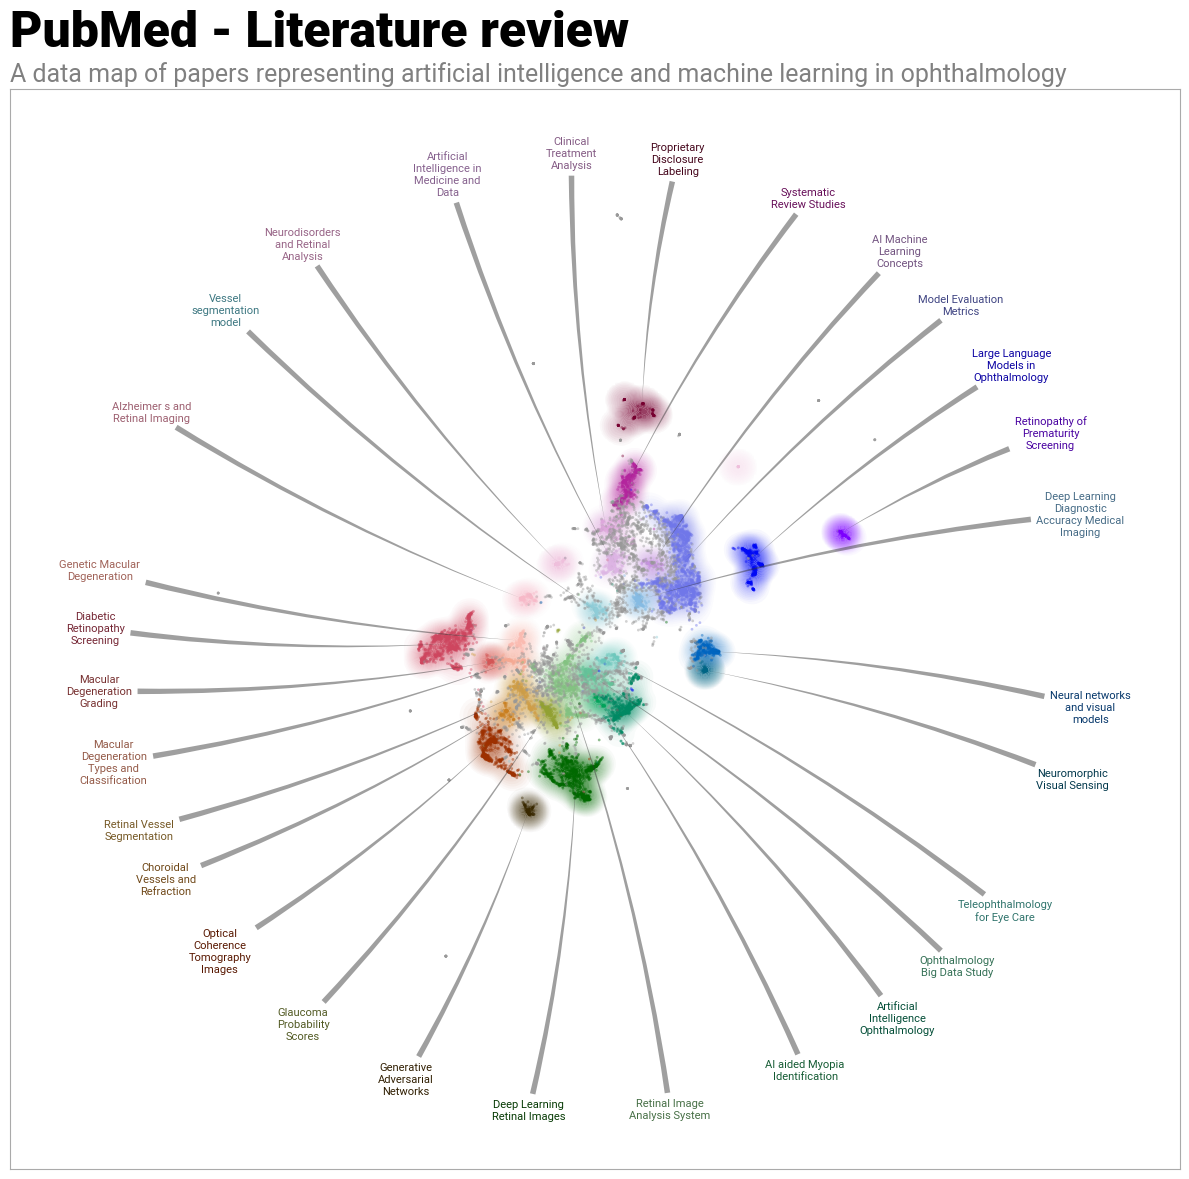

In [50]:
import datamapplot
import matplotlib.pyplot as plt

# Run the visualization
datamapplot.create_plot(
    reduced_embeddings,
    all_labels,

    use_medoids=True,

    # Follows matplotlib’s 'figsize' convention.
    # The actual size of the resulting plot (in pixels) will depend on the dots per inch (DPI)
    # setting in matplotlib.
    # By default that is set to 100 dots per inch for the standard backend, but it can vary.
    figsize=(12, 12),
    # If you really wish to have explicit control of the size of the resulting plot in pixels.
    dpi=100,

    title="PubMed - Literature review",
    sub_title="A data map of papers representing artificial intelligence and machine learning in ophthalmology",
    # Universally set a font family for the plot.
    fontfamily="Roboto",

    # Takes a dictionary of keyword arguments that is passed through to
    # matplotlib’s 'title' 'fontdict' arguments.
    title_keywords={
        "fontsize":36,
        "fontfamily":"Roboto Black"
    },
    # Takes a dictionary of keyword arguments that is passed through to
    # matplotlib’s 'suptitle' 'fontdict' arguments.
    sub_title_keywords={
        "fontsize":18,
    },

    # Takes a list of text labels to be highlighted.
    # Note: these labels need to match the exact text from your labels array that you are passing in.
    highlight_labels=[
        "Retinopathy Prematurity Screening",
    ],
    # Takes a dictionary of keyword arguments to be applied when styling the labels.
    highlight_label_keywords={
        "fontsize": 12,
        "fontweight": "bold",
        "bbox": {"boxstyle":"round"}
    },

    # By default DataMapPlot tries to automatically choose a size for the text that will allow
    # all the labels to be laid out well with no overlapping text. The layout algorithm will try
    # to accommodate the size of the text you specify here.
    label_font_size=8,
    label_wrap_width=16,
    label_linespacing=1.25,
    # Default is 1.5. Generally, the values of 1.0 and 2.0 are the extremes.
    # With 1.0 you will have more labels at the top and bottom.
    # With 2.0 you will have more labels on the left and right.
    label_direction_bias=1.3,
    # Controls how large the margin is around the exact bounding box of a label, which is the
    # bounding box used by the algorithm for collision/overlap detection.
    # The default is 1.0, which means the margin is the same size as the label itself.
    # Generally, the fewer labels you have the larger you can make the margin.
    label_margin_factor=2.0,
    # Labels are placed in rings around the core data map. This controls the starting radius for
    # the first ring. Note: you need to provide a radius in data coordinates from the center of the
    # data map.
    # The defaul is selected from the data itself, based on the distance from the center of the
    # most outlying points. Experiment and let the DataMapPlot algoritm try to clean it up.
    label_base_radius=15.0,

    # By default anything over 100,000 points uses datashader to create the scatterplot, while
    # plots with fewer points use matplotlib’s scatterplot.
    # If DataMapPlot is using datashader then the point-size should be an integer,
    # say 0, 1, 2, and possibly 3 at most. If however you are matplotlib scatterplot mode then you
    # have a lot more flexibility in the point-size you can use - and in general larger values will
    # be required. Experiment and see what works best.
    point_size=4,

    # Market type. There is only support if you are in matplotlib's scatterplot mode.
    # https://matplotlib.org/stable/api/markers_api.html
    marker_type="o",

    arrowprops={
        "arrowstyle":"wedge,tail_width=0.5",
        "connectionstyle":"arc3,rad=0.05",
        "linewidth":0,
        "fc":"#33333377"
    },

    add_glow=True,
    # Takes a dictionary of keywords that are passed to the 'add_glow_to_scatterplot' function.
    glow_keywords={
        "kernel_bandwidth": 0.75,  # controls how wide the glow spreads.
        "kernel": "cosine",        # controls the kernel type. Default is "gaussian". See https://scikit-learn.org/stable/modules/density.html#kernel-density.
        "n_levels": 32,            # controls how many "levels" there are in the contour plot.
        "max_alpha": 0.9,          # controls the translucency of the glow.
    },

    darkmode=False,
)

plt.tight_layout()

# Save the plot as a PDF file
plt.savefig('my_plot.pdf')
plt.savefig('my_plot.png')
plt.savefig('my_plot.svg')